# PROYECTO SPRINT 11 

- DESCRIPCION DE ACTIVIDADES DEL PROYECTO

Trabajas en una empresa emergente que vende productos alimenticios. Debes investigar el comportamiento del usuario para la aplicación de la empresa.

Primero, estudia el embudo de ventas. Descubre cómo los usuarios llegan a la etapa de compra. ¿Cuántos usuarios realmente llegan a esta etapa? ¿Cuántos se atascan en etapas anteriores? ¿Qué etapas en particular?

Luego, observa los resultados de un test A/A/B (sigue leyendo para obtener más información sobre los test A/A/B). Al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.

Los usuarios se dividen en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas. Descubre qué conjunto de fuentes produce mejores resultados.

Crear dos grupos A tiene ciertas ventajas. Podemos establecer el principio de que solo confiaremos en la exactitud de nuestras pruebas cuando los dos grupos de control sean similares. Si hay diferencias significativas entre los grupos A, esto puede ayudarnos a descubrir factores que pueden estar distorsionando los resultados. La comparación de grupos de control también nos dice cuánto tiempo y datos necesitaremos cuando realicemos más tests.

Utilizarás el mismo dataset para el análisis general y para el análisis A/A/B. En proyectos reales, los experimentos se llevan a cabo constantemente. El equipo de análisis estudia la calidad de una aplicación utilizando datos generales, sin prestar atención a si los usuarios participan en experimentos.

Descripción de los datos

Cada entrada de registro es una acción de usuario o un evento.

•	EventName: nombre del evento.

•	DeviceIDHash: identificador de usuario unívoco.

•	EventTimestamp: hora del evento.

•	ExpId: número de experimento. 246 y 247 son los grupos de control, y 248 es el grupo de prueba.


# Paso 1. Abrir el archivo de datos y leer la información general

In [1]:
# cargar librerias

import pandas as pd
import seaborn as sns
from scipy import stats as st
import numpy as np
import math as mth
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
from datetime import datetime
import scipy.stats as stats

In [2]:
# cargar archivo que se va a analizar

df_logs = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t') 

# Paso 2. Preparar los datos para el análisis

In [3]:
#revisar datos del data frame

df_logs.info()
print(df_logs.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'], dtype='object')


In [4]:
df_logs.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [5]:
#  Funcion para poner los encabezados en minusculas
def lowercase_columns(df):
    return [col.lower() for col in df.columns]

df_logs.columns = lowercase_columns(df_logs)


print(df_logs.columns)


Index(['eventname', 'deviceidhash', 'eventtimestamp', 'expid'], dtype='object')


In [6]:
#convertir columna de tiempo
df_logs['eventtimestamp'] = pd.to_datetime(df_logs['eventtimestamp'], unit='s')

# Columnas a convertir a object (excluyendo EventTimestamp)
columns_to_object = ['eventname', 'deviceidhash', 'expid']

# Aplicar la conversión
df_logs[columns_to_object] = df_logs[columns_to_object].astype(str)

# Verificar los tipos de datos
print(df_logs.dtypes)

eventname                 object
deviceidhash              object
eventtimestamp    datetime64[ns]
expid                     object
dtype: object


In [7]:
# identificar valores ausentes
print(df_logs.isna().sum())

eventname         0
deviceidhash      0
eventtimestamp    0
expid             0
dtype: int64


In [8]:
# Verificar strings vacías en columnas de tipo 'object'
object_cols = df_logs.select_dtypes(include='object').columns
for col in object_cols:
    empty_count = (df_logs[col].str.strip() == "").sum()  # Cuenta strings vacías o con espacios
    print(f"'{col}': {empty_count} valores vacíos/espacios")

'eventname': 0 valores vacíos/espacios
'deviceidhash': 0 valores vacíos/espacios
'expid': 0 valores vacíos/espacios


In [9]:
print("EventTimestamp mínimo:", df_logs['eventtimestamp'].min())
print("ExpId únicos:", df_logs['expid'].unique())

EventTimestamp mínimo: 2019-07-25 04:43:36
ExpId únicos: ['246' '248' '247']


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>Éxito</b> - ¡Muy bien planteada la introducción del proyecto! La descripción de las actividades está clara, contextualiza bien los objetivos de análisis del embudo de conversión y del experimento A/A/B. Además, se valora mucho que hayas presentado los datos desde el inicio, incluyendo información sobre la estructura del DataFrame y la conversión de tipos de datos. Esto es fundamental para garantizar un análisis limpio y confiable.

</div

# Paso 3. Estudiar y comprobar los datos

In [10]:
# ¿Cuántos eventos hay en los registros?
total_eventos = len(df_logs)
print("Total de eventos registrados:", total_eventos)

Total de eventos registrados: 244126


In [11]:
# ¿Cuántos usuarios hay en los registros?
num_usuarios = df_logs['deviceidhash'].nunique()

print(f"Número total de usuarios únicos: {num_usuarios}")

Número total de usuarios únicos: 7551


In [12]:
# ¿Cuál es el promedio de eventos por usuario?
# numero total de eventos
total_eventos = len(df_logs)

# Número de usuarios únicos
usuarios_unicos = df_logs['deviceidhash'].nunique()

# 3. Cálculo del promedio
promedio_eventos_por_usuario = total_eventos / usuarios_unicos

print(f"Promedio de eventos por usuario: {promedio_eventos_por_usuario:.2f}")

Promedio de eventos por usuario: 32.33


**- ¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima. Traza un histograma por fecha y hora. ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?**

In [13]:
# Obtener fechas mínima y máxima
fecha_min = df_logs['eventtimestamp'].min()
fecha_max = df_logs['eventtimestamp'].max()

print(f"Periodo cubierto: De {fecha_min} a {fecha_max}")

Periodo cubierto: De 2019-07-25 04:43:36 a 2019-08-07 21:15:17


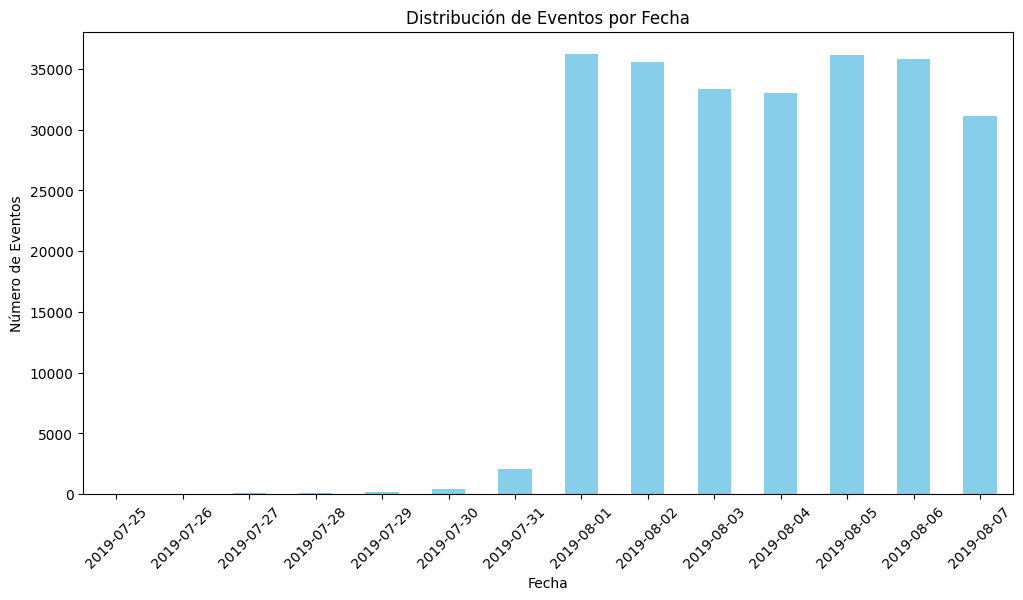

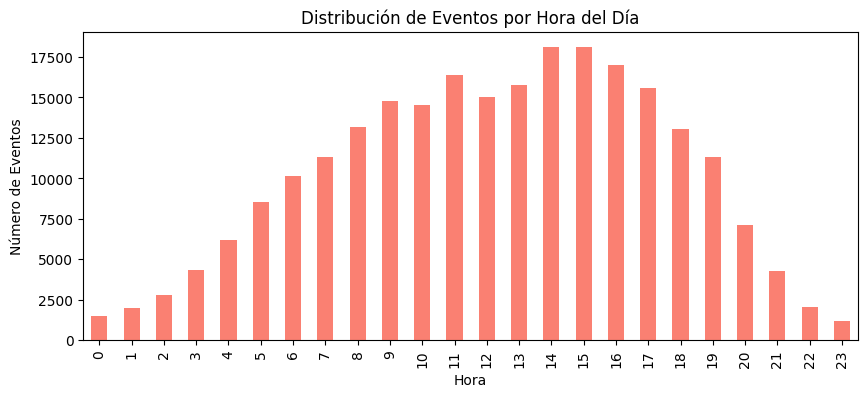

In [14]:
# Extraer fecha y hora
df_logs['Fecha'] = df_logs['eventtimestamp'].dt.date
df_logs['Hora'] = df_logs['eventtimestamp'].dt.hour

# Histograma por fecha
plt.figure(figsize=(12, 6))
df_logs['Fecha'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribución de Eventos por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Número de Eventos')
plt.xticks(rotation=45)
plt.show()

# Histograma por hora (promedio diario)
plt.figure(figsize=(10, 4))
df_logs['Hora'].value_counts().sort_index().plot(kind='bar', color='salmon')
plt.title('Distribución de Eventos por Hora del Día')
plt.xlabel('Hora')
plt.ylabel('Número de Eventos')
plt.show()

- En el grafico de fechas podemos observar que existen fechas con una cantidad de datos muy baja, asi que tendremos que revisar a partir de que fecha se tiene una cantidad considerable de datos y eliminar el resto, para evitar o reducir un posible sesgo.

In [15]:
# Calcular eventos por día
eventos_por_dia = df_logs.set_index('eventtimestamp').resample('D').size()

# Encontrar el día donde los eventos superan el 90% del promedio estable
umbral = eventos_por_dia.quantile(0.9) * 0.9  # 90% del percentil 90
fecha_completa = eventos_por_dia[eventos_por_dia >= umbral].index.min()

print(f"Los datos están completos a partir de: {fecha_completa}")
print('promedio de eventos filtrados por dia:', umbral.mean())

Los datos están completos a partir de: 2019-08-01 00:00:00
promedio de eventos filtrados por dia: 32423.129999999997


In [16]:
print(f"Periodo real con datos completos: De {fecha_completa} a {fecha_max}")

Periodo real con datos completos: De 2019-08-01 00:00:00 a 2019-08-07 21:15:17


In [17]:
# Filtrar datos completos
df_filtrado = df_logs[df_logs['eventtimestamp'] >= fecha_completa]

total_datos_filtrados = len(df_filtrado)
print("Total de datos filtrados:", total_datos_filtrados)
porcentaje_datos = (total_datos_filtrados / total_eventos) * 100
print(f"Porcentaje de datos filtrados: {porcentaje_datos:.2f} %")


Total de datos filtrados: 241298
Porcentaje de datos filtrados: 98.84 %


**- Despues de eliminar los datos de los dias con pocos eventos registrados, aun tenemos un 98.84% de los datos para continuar con nuestro analisis, esto es bastante bueno.**

In [18]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241298 entries, 2828 to 244125
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   eventname       241298 non-null  object        
 1   deviceidhash    241298 non-null  object        
 2   eventtimestamp  241298 non-null  datetime64[ns]
 3   expid           241298 non-null  object        
 4   Fecha           241298 non-null  object        
 5   Hora            241298 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 12.9+ MB


In [19]:
#verificar cuantos datos tenemos de cada grupo
conteo_por_expid = df_filtrado['expid'].value_counts()
print('Cantidad de datos de cada grupo:')
print(conteo_por_expid)

Cantidad de datos de cada grupo:
248    84726
246    79425
247    77147
Name: expid, dtype: int64


# Paso 4. Estudiar el embudo de eventos

**Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.**


In [106]:
#conteo de registros por evento
conteo_eventos = df_filtrado['eventname'].value_counts()
print(conteo_eventos)

MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: eventname, dtype: int64


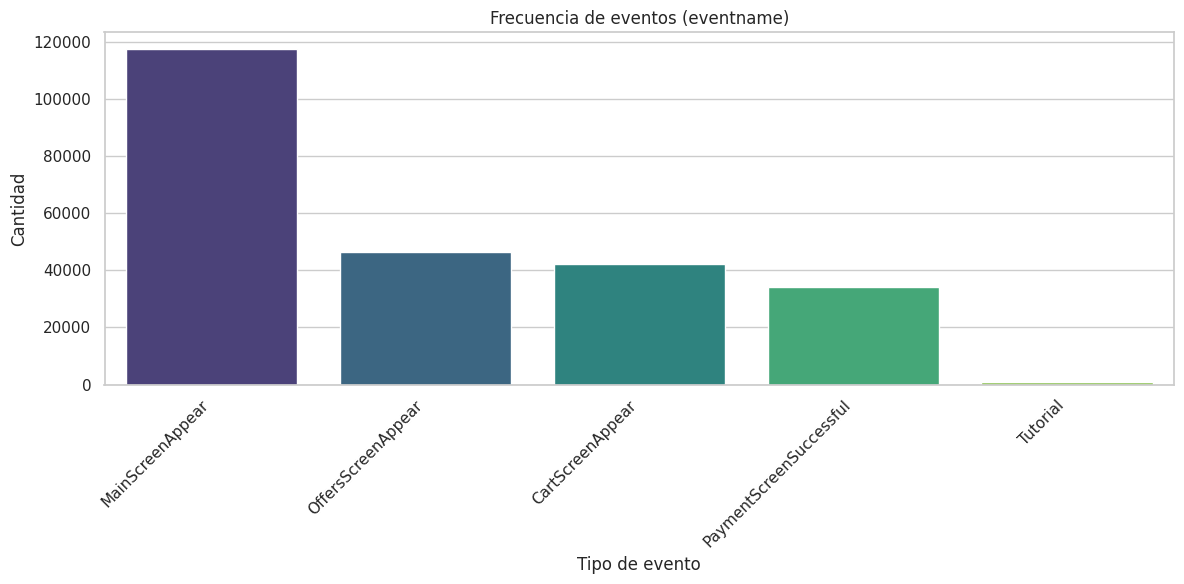

In [105]:
# convertir en DataFrame para personalizar más fácil
df_eventos = conteo_eventos.reset_index()
df_eventos.columns = ['eventname', 'frecuencia']

# Gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(data=df_eventos, x='eventname', y='frecuencia', palette='viridis')

plt.title('Frecuencia de eventos (eventname)')
plt.xlabel('Tipo de evento')
plt.ylabel('Cantidad')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.show()

- este grafico nos muestra la frecuencia en la que sucede cada evento y los tipos de eventos que tenemos registrados en nuestro archivo de analisis. Dependiendo de lo que queramos analizar, podemos identificar que la parte de compras realizadas esta cercana a los 20000 registros.

**Encuentra la cantidad de usuarios que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios.**

In [107]:
#calculo de usuarios unicos por evento
usuarios_por_evento = df_filtrado.groupby('eventname')['deviceidhash'].nunique().sort_values(ascending=False)
print(usuarios_por_evento)

eventname
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: deviceidhash, dtype: int64


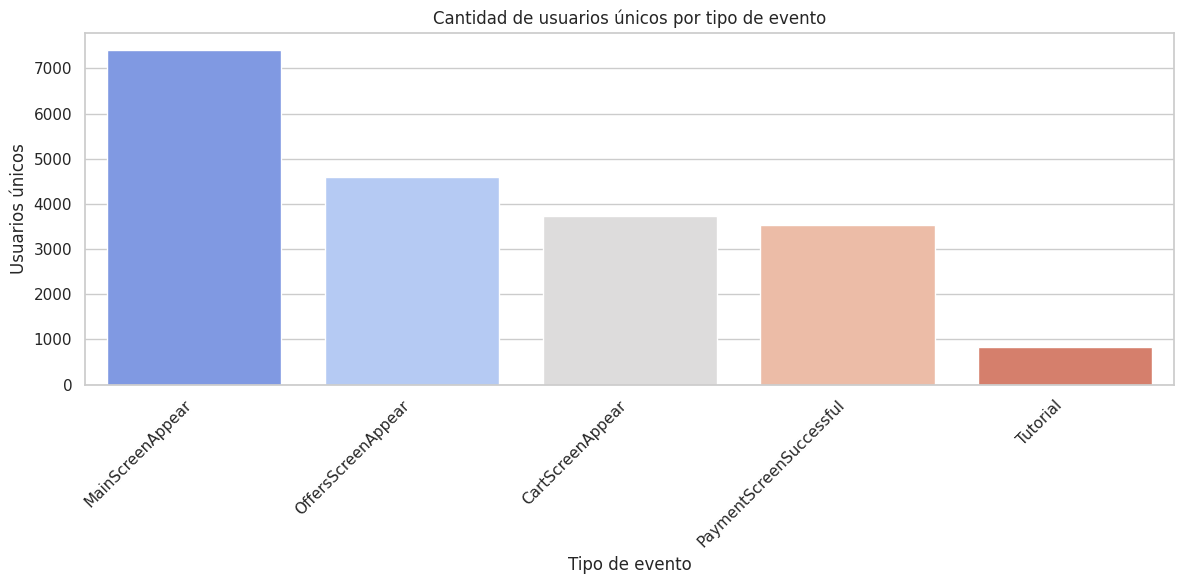

In [108]:
#grafica para visualizar usuarios por evento
df_usuarios_por_evento = usuarios_por_evento.reset_index()
df_usuarios_por_evento.columns = ['eventname', 'usuarios_unicos']

plt.figure(figsize=(12, 6))
sns.barplot(data=df_usuarios_por_evento, x='eventname', y='usuarios_unicos', palette='coolwarm')

plt.title('Cantidad de usuarios únicos por tipo de evento')
plt.xlabel('Tipo de evento')
plt.ylabel('Usuarios únicos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Calcula la proporción de usuarios que realizaron la acción al menos una vez.**

In [109]:
#calculo de proporcion de usuario que realizaron la accion una vez
total_usuarios = df_filtrado['deviceidhash'].nunique()
usuarios_por_evento = df_filtrado.groupby('eventname')['deviceidhash'].nunique()
proporcion_por_evento = (usuarios_por_evento / total_usuarios).sort_values(ascending=False)
print(proporcion_por_evento)

eventname
MainScreenAppear           0.984736
OffersScreenAppear         0.609636
CartScreenAppear           0.495620
PaymentScreenSuccessful    0.469737
Tutorial                   0.111495
Name: deviceidhash, dtype: float64


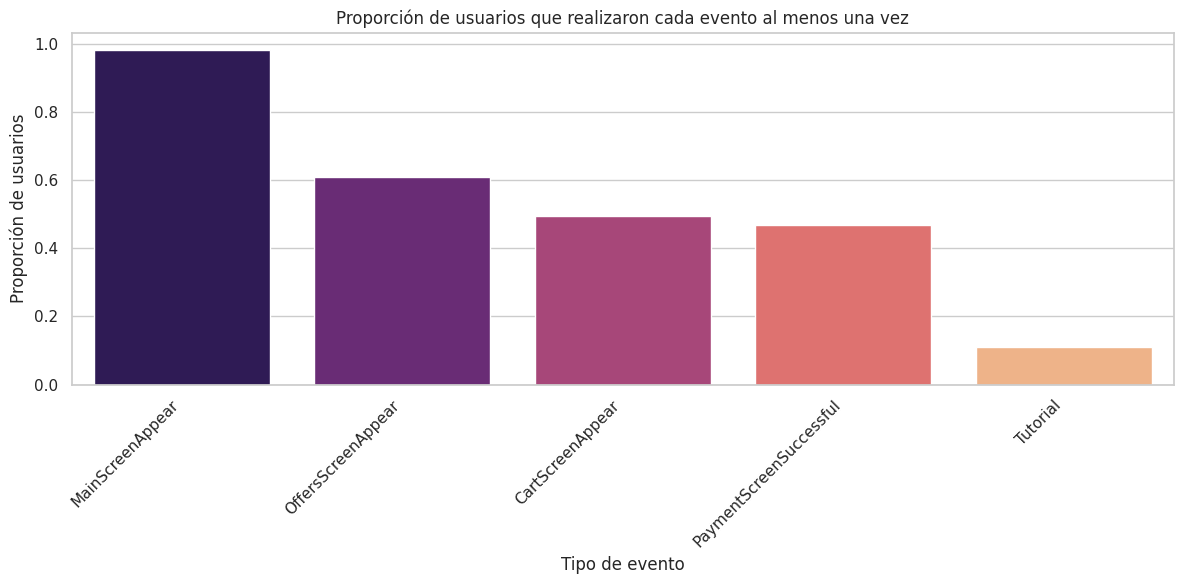

In [110]:
#grafica de proporcion de usuarios que realizaron cada evento
df_proporcion = proporcion_por_evento.reset_index()
df_proporcion.columns = ['eventname', 'proporcion']

plt.figure(figsize=(12, 6))
sns.barplot(data=df_proporcion, x='eventname', y='proporcion', palette='magma')

plt.title('Proporción de usuarios que realizaron cada evento al menos una vez')
plt.xlabel('Tipo de evento')
plt.ylabel('Proporción de usuarios')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**•	¿En qué orden crees que ocurrieron las acciones?**

RESPUESTA:

Despues de revisar los eventos registrados y su descripcion podriamos ordenar la ocurrencia de los eventos de la siguiente forma posible:

    1 - Main Screen Appear
    2 - Offers Screen Appear
    3 - Tutorial
    4 - Cart Screen Appear
    5 - Payment Screen Successful
    
**•   ¿Todas son parte de una sola secuencia?**

RESPUESTA:

No necesariamnente pueden ser de una sola secuencia, posiblemente el main screen appear y el offers screen appear sean eventos separados; y el tutorial aparenta ser opcional y por ende no todos los usuarios lo toman.


**•	Utiliza el embudo de eventos para encontrar la proporción de usuarios que pasan de una etapa a la siguiente. Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B.**

•	¿En qué etapa se pierden más usuarios?

para este analisis asumiremos la siguiente secuencia:

    1 - Main Screen Appear
    2 - Offers Screen Appear
    3 - Cart Screen Appear
    4 - Payment Screen Successful


In [26]:
#determinar la cantidad de usuarios por cada evento
usuarios_por_evento = df_filtrado.groupby('eventname')['deviceidhash'].nunique().sort_values(ascending=False)
print(usuarios_por_evento)

eventname
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: deviceidhash, dtype: int64


si consideramos el orden secuencial antes mencionado y la cantidad de usuarios por evento, podemos calcular la proporcion de usuarios que van pasando de un evento a otro


In [27]:
# calcular proporciones de usuarios unicos por evento
funnel_ordenado = usuarios_por_evento.loc[
    ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
]

proporciones = funnel_ordenado.values[1:] / funnel_ordenado.values[:-1]

for i in range(len(proporciones)):
    print(f"{funnel_ordenado.index[i]} ---> {funnel_ordenado.index[i+1]}: {proporciones[i]:.2%} de conversión")

MainScreenAppear ---> OffersScreenAppear: 61.91% de conversión
OffersScreenAppear ---> CartScreenAppear: 81.30% de conversión
CartScreenAppear ---> PaymentScreenSuccessful: 94.78% de conversión


In [28]:
#calculo de total de registros por evento
conteo_eventos = df_filtrado['eventname'].value_counts()
print(conteo_eventos)


MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: eventname, dtype: int64


In [29]:
# calcular proporciones de total de registros de usuarios por evento
funnel_ordenado2 = conteo_eventos.loc[
    ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
]

proporciones2 = funnel_ordenado2.values[1:] / funnel_ordenado2.values[:-1]

for i in range(len(proporciones2)):
    print(f"{funnel_ordenado2.index[i]} ---> {funnel_ordenado2.index[i+1]}: {proporciones2[i]:.2%} de conversión")

MainScreenAppear ---> OffersScreenAppear: 39.47% de conversión
OffersScreenAppear ---> CartScreenAppear: 91.40% de conversión
CartScreenAppear ---> PaymentScreenSuccessful: 80.52% de conversión


**•	¿En qué etapa pierdes más usuarios?**

RESPUESTA:

Considerando el orden secuencial planteado, en la etapa donde se pierden mas usuarios es de la etapa de Main Screen Apper a la etapa de Offers Screen Appear. 

**•	¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?**

In [30]:
pasos_embudo = [
    "MainScreenAppear",
    "OffersScreenAppear",
    "CartScreenAppear",
    "PaymentScreenSuccessful"
]

# Agrupar por usuario y obtener eventos únicos que hizo cada uno
eventos_por_usuario = df_filtrado.groupby('deviceidhash')['eventname'].unique()

# Verificar para cada usuario si hizo todos los eventos del embudo (sin importar orden)
usuarios_con_todos = eventos_por_usuario[eventos_por_usuario.apply(lambda eventos: set(pasos_embudo).issubset(set(eventos)))]

# Calcular valores
usuarios_totales = df_filtrado['deviceidhash'].nunique()
usuarios_completaron = len(usuarios_con_todos)
porcentaje = usuarios_completaron / usuarios_totales * 100

print(f"{usuarios_completaron} de {usuarios_totales} usuarios realizaron todos los eventos del viaje.")
print(f"Eso representa un {porcentaje:.2f}% del total.")

3429 de 7534 usuarios realizaron todos los eventos del viaje.
Eso representa un 45.51% del total.


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>Éxito</b> - ¡Excelente trabajo en esta sección! Has realizado un análisis exploratorio muy sólido: el conteo de eventos, usuarios únicos y promedio de eventos por usuario están correctamente calculados y bien presentados. Además, el análisis temporal es destacable: los histogramas por fecha y hora ayudan a visualizar la distribución de los datos y tomar decisiones informadas. También es un gran acierto que hayas identificado el punto de corte para garantizar calidad en los datos y que hayas filtrado sin perder información valiosa (más del 98% conservado). Este enfoque mejora significativamente la confiabilidad del análisis posterior. 👏📊

</div>


# Paso 5. Estudiar los resultados del experimento

•	¿Cuántos usuarios hay en cada grupo?


In [31]:
#verificar cuantos datos tenemos de cada grupo
conteo_por_expid = df_filtrado['expid'].value_counts()
print('Cantidad de datos de cada grupo:')
print(conteo_por_expid)


Cantidad de datos de cada grupo:
248    84726
246    79425
247    77147
Name: expid, dtype: int64


In [32]:
#verificar cuantos usuarios unicos hay en cada grupo
usuarios_por_grupo = df_filtrado.groupby('expid')['deviceidhash'].nunique()
print('Usuarios únicos por grupo:')
print(usuarios_por_grupo)

Usuarios únicos por grupo:
expid
246    2484
247    2513
248    2537
Name: deviceidhash, dtype: int64


**•	Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.**

In [59]:
# Filtrar solo los grupos A/A (246 y 247)
df_aa = df_filtrado[df_filtrado['expid'].isin(['246', '247'])]

# Usuarios únicos por grupo
total_246 = df_aa[(df_aa['expid'] == '246')]['deviceidhash'].nunique()
total_247 = df_aa[(df_aa['expid'] == '247')]['deviceidhash'].nunique()


# Obtener éxitos (únicos que llegaron a PaymentScreenSuccessful)
pago_246 = df_aa[(df_aa['expid'] == '246') & (df_aa['eventname'] == 'PaymentScreenSuccessful')]['deviceidhash'].nunique()
pago_247 = df_aa[(df_aa['expid'] == '247') & (df_aa['eventname'] == 'PaymentScreenSuccessful')]['deviceidhash'].nunique()

alpha = 0.05  # Nivel de significación

successes = np.array([pago_246, pago_247])
trials = np.array([total_246, total_247])

# Proporciones
p1 = successes[0] / trials[0]
p2 = successes[1] / trials[1]

# Proporción combinada
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# Diferencia
difference = p1 - p2

# Estadístico Z
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# Distribución normal estándar
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2  # Two-tailed test

# --- Resultados ---
print("=== Comparación Grupos 246 vs 247 ===")
print(f"Usuarios totales en:")
print(f"  • Grupo 246: {total_246}")
print(f"  • Grupo 247: {total_247}\n")

print(f"Usuarios que llegaron a PaymentScreenSuccessful:")
print(f"  • Grupo 246: {pago_246} ({p1:.2%})")
print(f"  • Grupo 247: {pago_247} ({p2:.2%})\n")

print(f"Diferencia absoluta: {difference:.4f} ({difference:.2%})")
print(f"Estadístico Z: {z_value:.4f}")
print(f"P-valor: {p_value:.6f}")

# Conclusión
if p_value < alpha:
    print("\nConclusión: Existe diferencia significativa (rechazamos H0)")
else:
    print("\nConclusión: NO hay diferencia significativa (no se rechaza H0)")

=== Comparación Grupos 246 vs 247 ===
Usuarios totales en:
  • Grupo 246: 2484
  • Grupo 247: 2513

Usuarios que llegaron a PaymentScreenSuccessful:
  • Grupo 246: 1200 (48.31%)
  • Grupo 247: 1158 (46.08%)

Diferencia absoluta: 0.0223 (2.23%)
Estadístico Z: 1.5780
P-valor: 0.114567

Conclusión: NO hay diferencia significativa (no se rechaza H0)


**•	Selecciona el evento más popular.**

In [35]:
# Contar eventos por tipo en cada grupo
eventos_246 = grupo_246['eventname'].value_counts()
eventos_247 = grupo_247['eventname'].value_counts()
eventos_248 = grupo_248['eventname'].value_counts()

# Mostrar el evento más popular en cada grupo
print("Evento más popular en grupo 246:")
print(eventos_246.head(1))

print("\nEvento más popular en grupo 247:")
print(eventos_247.head(1))

Evento más popular en grupo 246:
MainScreenAppear    37708
Name: eventname, dtype: int64

Evento más popular en grupo 247:
MainScreenAppear    39123
Name: eventname, dtype: int64


 **En cada uno de los grupos de control, encuentra la cantidad de usuarios que realizaron esta acción. Encuentra su proporción.**

In [60]:
# Filtrar solo el primer evento (MainScreenAppear) en grupos de control
df_primer_evento = df_filtrado[
    (df_filtrado['eventname'] == 'MainScreenAppear') & 
    (df_filtrado['expid'].isin(['246', '247']))
]

# Calcular usuarios únicos por grupo
conteo_usuarios = df_primer_evento.groupby('expid')['deviceidhash'].nunique()

# Calcular proporciones relativas
total_usuarios = conteo_usuarios.sum()
proporciones = conteo_usuarios / total_usuarios

# Crear tabla de resultados
resultados = pd.DataFrame({
    'Grupo': conteo_usuarios.index,
    'Usuarios_Únicos': conteo_usuarios.values,
    'Proporción': proporciones.values
})

# Mostrar resultados
print("=== Análisis del Primer Evento (MainScreenAppear) ===")
print(resultados)

# Diferencia absoluta y relativa
diferencia_abs = conteo_usuarios['247'] - conteo_usuarios['246']
diferencia_rel = diferencia_abs / conteo_usuarios['246']

print(f"\nDiferencia absoluta (247 - 246): {diferencia_abs} usuarios")
print(f"Diferencia relativa: {diferencia_rel:.2%}")

=== Análisis del Primer Evento (MainScreenAppear) ===
  Grupo  Usuarios_Únicos  Proporción
0   246             2450    0.497361
1   247             2476    0.502639

Diferencia absoluta (247 - 246): 26 usuarios
Diferencia relativa: 1.06%


**Comprueba si la diferencia entre los grupos es estadísticamente significativa.** 

In [102]:
# Obtener conteos de usuarios únicos por grupo
grupo_246 = df_primer_evento[df_primer_evento['expid'] == '246']['deviceidhash'].nunique()
grupo_247 = df_primer_evento[df_primer_evento['expid'] == '247']['deviceidhash'].nunique()

alpha = 0.05  # Nivel de significación
successes = np.array([grupo_246, grupo_247])  # Usuarios en cada grupo
trials = np.array([grupo_246 + grupo_247, grupo_246 + grupo_247])  # Total de usuarios en ambos grupos

# Proporciones observadas
p1 = successes[0] / trials[0]
p2 = successes[1] / trials[1]

# Proporción combinada (pooled proportion)
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# Diferencia entre proporciones
difference = p1 - p2

# Estadístico Z
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# Valor p
distr = st.norm(0, 1)  # Distribución normal estándar
p_value = (1 - distr.cdf(abs(z_value))) * 2

# Resultados
print(f"=== Comparación de Grupos (MainScreenAppear) ===")
print(f"Grupo 246: {grupo_246}/{trials[0]} = {p1:.4f} ({p1:.2%})")
print(f"Grupo 247: {grupo_247}/{trials[1]} = {p2:.4f} ({p2:.2%})")
print(f"\nDiferencia: {difference:.4f} ({difference:.2%})")
print(f"Estadístico Z: {z_value:.4f}")
print(f"P-valor: {p_value:.6f}")

# Conclusión
if p_value < alpha:
    print("\nConclusión: Existe diferencia estadísticamente significativa (rechazamos H0)")
else:
    print("\nConclusión: No hay diferencia significativa (no se rechaza H0)")

=== Comparación de Grupos (MainScreenAppear) ===
Grupo 246: 2450/4926 = 0.4974 (49.74%)
Grupo 247: 2476/4926 = 0.5026 (50.26%)

Diferencia: -0.0053 (-0.53%)
Estadístico Z: -0.5239
P-valor: 0.600354

Conclusión: No hay diferencia significativa (no se rechaza H0)


**- Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?**

In [72]:
def analizar_evento(df, evento, grupo_a='246', grupo_a2='247'):
    # Filtrar por grupo
    grupo_246 = df_aa[df_aa['expid'] == grupo_a]
    grupo_247 = df_aa[df_aa['expid'] == grupo_a2]

    # Totales de usuarios por grupo
    usuarios_totales_246 = grupo_246['deviceidhash'].nunique()
    usuarios_totales_247 = grupo_247['deviceidhash'].nunique()
    #usuarios_totales =  usuarios_totales_246 + uruarios_totales

    # Usuarios que realizaron el evento
    usuarios_evento_246 = grupo_246[grupo_246['eventname'] == evento]['deviceidhash'].nunique()
    usuarios_evento_247 = grupo_247[grupo_247['eventname'] == evento]['deviceidhash'].nunique()

    # Proporciones
    p1 = usuarios_evento_246 / usuarios_totales_246
    p2 = usuarios_evento_247 / usuarios_totales_247
    p_combined = (usuarios_evento_246 + usuarios_evento_247) / (usuarios_totales_246 + usuarios_totales_247)
    difference = p1 - p2

    # Z-test
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/usuarios_totales_246 + 1/usuarios_totales_247))
    p_value = (1 - st.norm.cdf(abs(z_value))) * 2

    # Resultados
    print(f"\n Análisis del evento: '{evento}'")
    print(f"Grupo {grupo_a}: {usuarios_evento_246} usuarios ({p1:.2%})")
    print(f"Grupo {grupo_a2}: {usuarios_evento_247} usuarios ({p2:.2%})")
    print(f"Diferencia de proporciones: {difference:.2%}")
    print(f"Z-score: {z_value:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value < 0.05:
        print("Existe Diferencia estadísticamente significativa (p < 0.05)")
    else:
        print("No hay diferencia significativa (p ≥ 0.05)")

In [73]:
analizar_evento(df_filtrado, "MainScreenAppear")
analizar_evento(df_filtrado, "OffersScreenAppear")
analizar_evento(df_filtrado, "CartScreenAppear")
analizar_evento(df_filtrado, "PaymentScreenSuccessful")


 Análisis del evento: 'MainScreenAppear'
Grupo 246: 2450 usuarios (98.63%)
Grupo 247: 2476 usuarios (98.53%)
Diferencia de proporciones: 0.10%
Z-score: 0.3093
P-value: 0.7571
No hay diferencia significativa (p ≥ 0.05)

 Análisis del evento: 'OffersScreenAppear'
Grupo 246: 1542 usuarios (62.08%)
Grupo 247: 1520 usuarios (60.49%)
Diferencia de proporciones: 1.59%
Z-score: 1.1550
P-value: 0.2481
No hay diferencia significativa (p ≥ 0.05)

 Análisis del evento: 'CartScreenAppear'
Grupo 246: 1266 usuarios (50.97%)
Grupo 247: 1238 usuarios (49.26%)
Diferencia de proporciones: 1.70%
Z-score: 1.2034
P-value: 0.2288
No hay diferencia significativa (p ≥ 0.05)

 Análisis del evento: 'PaymentScreenSuccessful'
Grupo 246: 1200 usuarios (48.31%)
Grupo 247: 1158 usuarios (46.08%)
Diferencia de proporciones: 2.23%
Z-score: 1.5780
P-value: 0.1146
No hay diferencia significativa (p ≥ 0.05)


In [77]:
# Combinar los conteos en un DataFrame
comparacion_eventos = pd.DataFrame({
    'Grupo 246': eventos_246,
    'Grupo 247': eventos_247
}).fillna(0).astype(int)

print(comparacion_eventos[['Grupo 246', 'Grupo 247']])

                         Grupo 246  Grupo 247
MainScreenAppear             37708      39123
OffersScreenAppear           14773      15182
CartScreenAppear             14711      12456
PaymentScreenSuccessful      11910      10043
Tutorial                       323        343


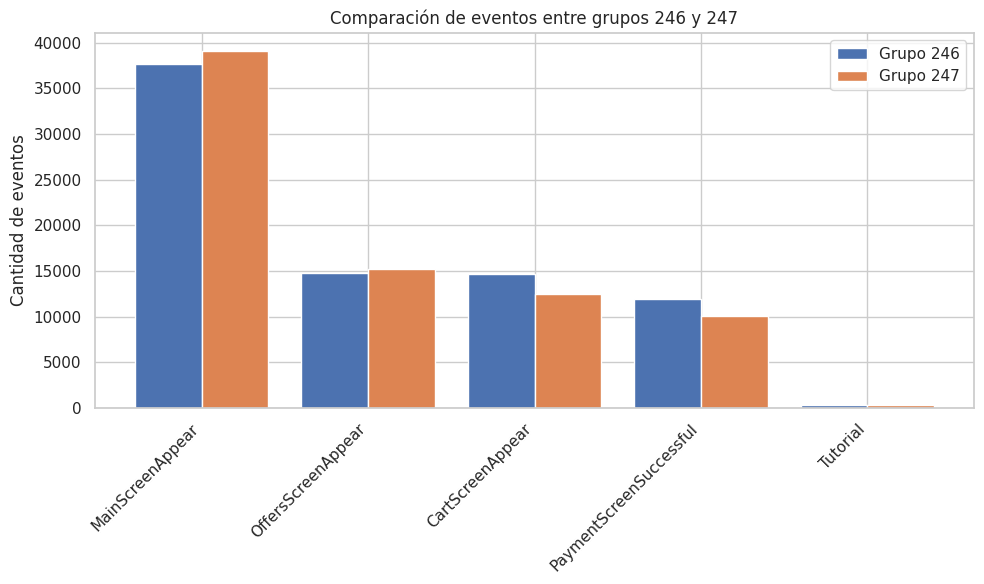

In [66]:
# Contar eventos por tipo para cada grupo
eventos_246 = df_filtrado[df_filtrado['expid'] == '246']['eventname'].value_counts()
eventos_247 = df_filtrado[df_filtrado['expid'] == '247']['eventname'].value_counts()

# Unir en un solo DataFrame
comparacion_eventos = pd.DataFrame({
    'Grupo 246': eventos_246,
    'Grupo 247': eventos_247
}).fillna(0).astype(int)

# Reset index para graficar
comparacion_eventos = comparacion_eventos.reset_index().rename(columns={'index': 'eventname'})

# Configurar estilo de Seaborn
sns.set(style="whitegrid")

# Crear gráfica
plt.figure(figsize=(10, 6))
bar_width = 0.4
x = range(len(comparacion_eventos))

plt.bar([i - bar_width/2 for i in x], comparacion_eventos['Grupo 246'], width=bar_width, label='Grupo 246')
plt.bar([i + bar_width/2 for i in x], comparacion_eventos['Grupo 247'], width=bar_width, label='Grupo 247')

# Etiquetas y título
plt.xticks(ticks=x, labels=comparacion_eventos['eventname'], rotation=45, ha='right')
plt.ylabel("Cantidad de eventos")
plt.title("Comparación de eventos entre grupos 246 y 247")
plt.legend()
plt.tight_layout()

# Mostrar
plt.show()


CONCLUSION:
Despues de realizar los calculos y los graficos, podemos determinar que los grupos se dividieron correctamente para la prueba A/A

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>Éxito</b> - ¡Fantástico trabajo con el análisis estadístico del experimento A/A! La forma en que verificas la distribución de usuarios, realizas pruebas de hipótesis con Z-test, y concluyes sobre la significancia estadística demuestra un sólido dominio de experimentación controlada. Además, la implementación de funciones reutilizables como analizar_evento() muestra buenas prácticas de codificación y te permite escalar el análisis eficientemente para múltiples eventos. También es destacable el uso de visualizaciones claras para reforzar los hallazgos. ¡Sigue aplicando esta rigurosidad en tus análisis! 📈👏

</div>

# •	Hacer los mismos calculos para el grupo con fuentes alteradas. (grupo 248) 

**Comprueba si la diferencia entre los grupos 248 y 246 es estadísticamente significativa.**

In [89]:
# Filtrar solo los grupos A/B (246 y 248)
df_AB = df_filtrado[df_filtrado['expid'].isin(['246', '248'])]

# Usuarios únicos por grupo
total_246 = df_AB[(df_AB['expid'] == '246')]['deviceidhash'].nunique()
total_248 = df_AB[(df_AB['expid'] == '248')]['deviceidhash'].nunique()

def analizar_evento_AB(df, evento, grupo_A='246', grupo_B='248'):
    # Filtrar por grupo
    grupo_246 = df_AB[df_AB['expid'] == grupo_A]
    grupo_248 = df_AB[df_AB['expid'] == grupo_B]

    # Totales de usuarios por grupo
    usuarios_totales_246 = grupo_246['deviceidhash'].nunique()
    usuarios_totales_248 = grupo_248['deviceidhash'].nunique()
    

    # Usuarios que realizaron el evento
    usuarios_evento_246 = grupo_246[grupo_246['eventname'] == evento]['deviceidhash'].nunique()
    usuarios_evento_248 = grupo_248[grupo_248['eventname'] == evento]['deviceidhash'].nunique()

    # Proporciones
    p1 = usuarios_evento_246 / usuarios_totales_246
    p2 = usuarios_evento_248 / usuarios_totales_248
    p_combined = (usuarios_evento_246 + usuarios_evento_248) / (usuarios_totales_246 + usuarios_totales_248)
    difference = p1 - p2

    # Z-test
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/usuarios_totales_246 + 1/usuarios_totales_248))
    p_value = (1 - st.norm.cdf(abs(z_value))) * 2

    # Resultados
    print(f"\n Análisis del evento: '{evento}'")
    print(f"Grupo {grupo_A}: {usuarios_evento_246} usuarios ({p1:.2%})")
    print(f"Grupo {grupo_B}: {usuarios_evento_248} usuarios ({p2:.2%})")
    print(f"Diferencia de proporciones: {difference:.2%}")
    print(f"Z-score: {z_value:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value < 0.05:
        print("Existe Diferencia estadísticamente significativa (p < 0.05)")
    else:
        print("No hay diferencia significativa (p ≥ 0.05)")

In [71]:
analizar_evento_AB(df_AB, "MainScreenAppear")
analizar_evento_AB(df_AB, "OffersScreenAppear")
analizar_evento_AB(df_AB, "CartScreenAppear")
analizar_evento_AB(df_AB, "PaymentScreenSuccessful")


 Análisis del evento: 'MainScreenAppear'
Grupo 246: 2450 usuarios (98.63%)
Grupo 248: 2493 usuarios (98.27%)
Diferencia de proporciones: 0.37%
Z-score: 1.0473
P-value: 0.2950
No hay diferencia significativa (p ≥ 0.05)

 Análisis del evento: 'OffersScreenAppear'
Grupo 246: 1542 usuarios (62.08%)
Grupo 248: 1531 usuarios (60.35%)
Diferencia de proporciones: 1.73%
Z-score: 1.2581
P-value: 0.2084
No hay diferencia significativa (p ≥ 0.05)

 Análisis del evento: 'CartScreenAppear'
Grupo 246: 1266 usuarios (50.97%)
Grupo 248: 1230 usuarios (48.48%)
Diferencia de proporciones: 2.48%
Z-score: 1.7599
P-value: 0.0784
No hay diferencia significativa (p ≥ 0.05)

 Análisis del evento: 'PaymentScreenSuccessful'
Grupo 246: 1200 usuarios (48.31%)
Grupo 248: 1181 usuarios (46.55%)
Diferencia de proporciones: 1.76%
Z-score: 1.2474
P-value: 0.2123
No hay diferencia significativa (p ≥ 0.05)


**Comprueba si la diferencia entre los grupos 248 y 247 es estadísticamente significativa.**

In [103]:
# Filtrar solo los grupos A2/B (247 y 248)
df_A2B = df_filtrado[df_filtrado['expid'].isin(['247', '248'])]

# Usuarios únicos por grupo
total_247 = df_A2B[(df_A2B['expid'] == '247')]['deviceidhash'].nunique()
total_248 = df_A2B[(df_A2B['expid'] == '248')]['deviceidhash'].nunique()

def analizar_evento_A2B(df, evento, grupo_A2='247', grupo_B='248'):
    # Filtrar por grupo
    grupo_247 = df_A2B[df_A2B['expid'] == grupo_A2]
    grupo_248 = df_A2B[df_A2B['expid'] == grupo_B]

    # Totales de usuarios por grupo
    usuarios_totales_247 = grupo_247['deviceidhash'].nunique()
    usuarios_totales_248 = grupo_248['deviceidhash'].nunique()

    # Usuarios que realizaron el evento
    usuarios_evento_247 = grupo_247[grupo_247['eventname'] == evento]['deviceidhash'].nunique()
    usuarios_evento_248 = grupo_248[grupo_248['eventname'] == evento]['deviceidhash'].nunique()

    # Proporciones
    p1 = usuarios_evento_247 / usuarios_totales_247
    p2 = usuarios_evento_248 / usuarios_totales_248
    p_combined = (usuarios_evento_247 + usuarios_evento_248) / (usuarios_totales_247 + usuarios_totales_248)
    difference = p1 - p2

    # Z-test
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/usuarios_totales_247 + 1/usuarios_totales_248))
    p_value = (1 - st.norm.cdf(abs(z_value))) * 2

    # Resultados
    print(f"\n Análisis del evento: '{evento}'")
    print(f"Grupo {grupo_A2}: {usuarios_evento_247} usuarios ({p1:.2%})")
    print(f"Grupo {grupo_B}: {usuarios_evento_248} usuarios ({p2:.2%})")
    print(f"Diferencia de proporciones: {difference:.2%}")
    print(f"Z-score: {z_value:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value < 0.05:
        print("Existe Diferencia estadísticamente significativa (p < 0.05)")
    else:
        print("No hay diferencia significativa (p ≥ 0.05)")

In [104]:
analizar_evento_A2B(df_A2B, "MainScreenAppear")
analizar_evento_A2B(df_A2B, "OffersScreenAppear")
analizar_evento_A2B(df_A2B, "CartScreenAppear")
analizar_evento_A2B(df_A2B, "PaymentScreenSuccessful")


 Análisis del evento: 'MainScreenAppear'
Grupo 247: 2476 usuarios (98.53%)
Grupo 248: 2493 usuarios (98.27%)
Diferencia de proporciones: 0.26%
Z-score: 0.7410
P-value: 0.4587
No hay diferencia significativa (p ≥ 0.05)

 Análisis del evento: 'OffersScreenAppear'
Grupo 247: 1520 usuarios (60.49%)
Grupo 248: 1531 usuarios (60.35%)
Diferencia de proporciones: 0.14%
Z-score: 0.1007
P-value: 0.9198
No hay diferencia significativa (p ≥ 0.05)

 Análisis del evento: 'CartScreenAppear'
Grupo 247: 1238 usuarios (49.26%)
Grupo 248: 1230 usuarios (48.48%)
Diferencia de proporciones: 0.78%
Z-score: 0.5554
P-value: 0.5786
No hay diferencia significativa (p ≥ 0.05)

 Análisis del evento: 'PaymentScreenSuccessful'
Grupo 247: 1158 usuarios (46.08%)
Grupo 248: 1181 usuarios (46.55%)
Diferencia de proporciones: -0.47%
Z-score: -0.3354
P-value: 0.7373
No hay diferencia significativa (p ≥ 0.05)


In [78]:
# Combinar los conteos en un DataFrame
comparacion_eventos = pd.DataFrame({
    'Grupo 246': eventos_246,
    'Grupo 247': eventos_247,
    'Grupo 248': eventos_248
}).fillna(0).astype(int)

print(comparacion_eventos[['Grupo 246', 'Grupo 247', 'Grupo 248']])

                         Grupo 246  Grupo 247  Grupo 248
MainScreenAppear             37708      39123      40600
OffersScreenAppear           14773      15182      16395
CartScreenAppear             14711      12456      15198
PaymentScreenSuccessful      11910      10043      12160
Tutorial                       323        343        373


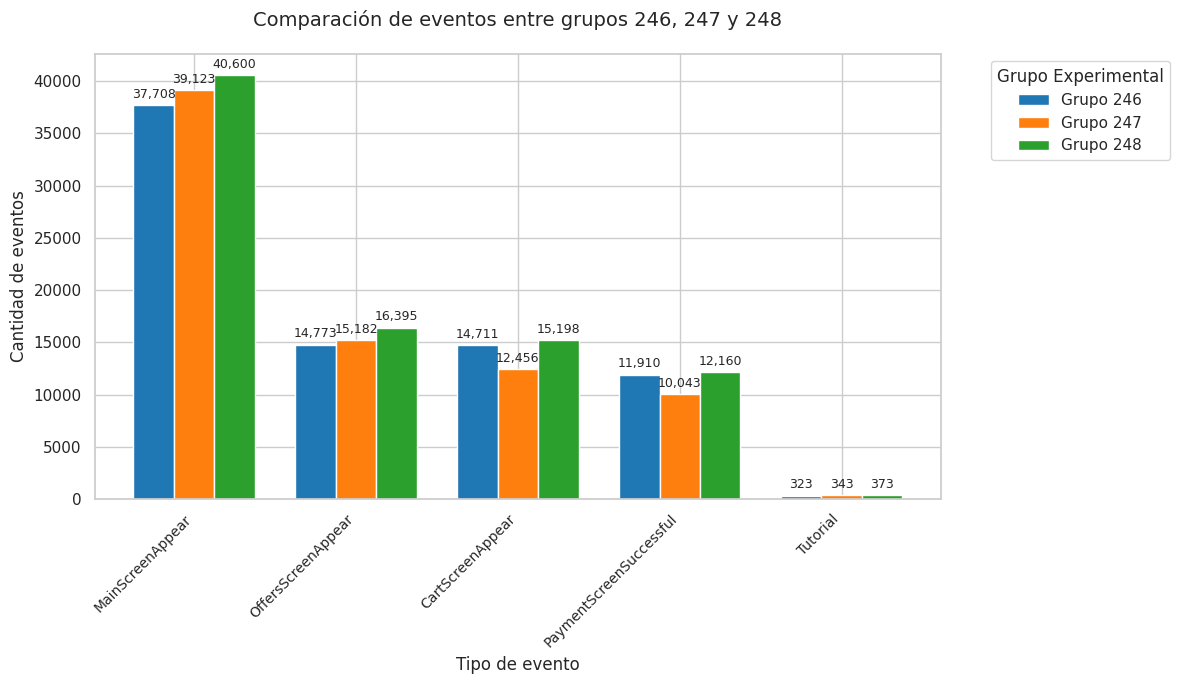

In [90]:
#Contar eventos por tipo para cada grupo
eventos_246 = df_filtrado[df_filtrado['expid'] == '246']['eventname'].value_counts()
eventos_247 = df_filtrado[df_filtrado['expid'] == '247']['eventname'].value_counts()
eventos_248 = df_filtrado[df_filtrado['expid'] == '248']['eventname'].value_counts()

#Unir en un solo DataFrame y ordenar por evento
comparacion_eventos = pd.DataFrame({
    'Grupo 246': eventos_246,
    'Grupo 247': eventos_247,
    'Grupo 248': eventos_248
}).fillna(0).astype(int)

# Configuración del gráfico
plt.figure(figsize=(12, 7))
sns.set(style="whitegrid")
bar_width = 0.25
x = range(len(comparacion_eventos))

# Posicionamiento preciso de las barras
plt.bar([i - bar_width for i in x], comparacion_eventos['Grupo 246'], width=bar_width, label='Grupo 246', color='#1f77b4')
plt.bar([i for i in x], comparacion_eventos['Grupo 247'], width=bar_width, label='Grupo 247', color='#ff7f0e')
plt.bar([i + bar_width for i in x], comparacion_eventos['Grupo 248'], width=bar_width, label='Grupo 248', color='#2ca02c')

# Personalización del gráfico
plt.xticks(ticks=x, labels=comparacion_eventos.index, rotation=45, ha='right', fontsize=10)
plt.ylabel("Cantidad de eventos", fontsize=12)
plt.xlabel("Tipo de evento", fontsize=12)
plt.title("Comparación de eventos entre grupos 246, 247 y 248", fontsize=14, pad=20)

# Añadir valores encima de las barras
for i in x:
    for j, grupo in enumerate(['Grupo 246', 'Grupo 247', 'Grupo 248']):
        height = comparacion_eventos[grupo].iloc[i]
        plt.text(i + (j-1)*bar_width, height + max(comparacion_eventos.max())*0.01, 
                 f'{height:,}', ha='center', va='bottom', fontsize=9)

plt.legend(title='Grupo Experimental', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# CONCLUSION GENERAL

Despues de realizar los analisis entre grupos de control A/A ( grupos 246/247), pudimos ver que los grupos de control estaban bien distribuidos y no tenian diferencia significativa entre si, lo que nos indicaba una prueba estable y confiable para poder realizar analisis y comparaciones con el grupo de prueba B (grupo 248).

Al finalizar las comparaciones y realizado las pruebas estadisticas y graficas de los datos obtenidos; y no se encontro evidencia estadisticamente significativamente que nos pudiera indicar que el nuevo diseño de la aplicacion tenga algun impacto negativo hacia los usuarios de la misma; y de igual forma tampoco se pudo observar un impacto de manera inversa, esto es, que aumentaran las ventas o los ingresos; por lo que el cambio de diseño en la aplicacion es confiable y se puede implementar, considerando que la razon de evitar el cambio era por temor a un impacto negativo hacia los clientes, y con los estudios realizados, esto no sucede. Por lo que la sugerencia es SI realizar la implementacion del nuevo diseño de la aplicacion.


# Comentario General del Revisor

<div class="alert alert-block alert-success">

<b>Comentario del revisor</b> <a class="tocSkip"></a>

¡Felicidades! Tu proyecto está <b>aprobado</b>. Has demostrado un excelente manejo del análisis de datos, diseño experimental y validación estadística. El enfoque en validar cuidadosamente la integridad de los datos, establecer comparaciones sólidas entre grupos y extraer conclusiones accionables es digno de reconocimiento.

#### Puntos Positivos:

- **Control de calidad en los datos:** Identificaste correctamente el punto donde los datos se vuelven estables y filtraste inteligentemente para evitar sesgos.
- **Embudo de conversión:** Muy bien definido, con métricas claras de paso a paso, y una interpretación concisa sobre dónde se pierde más tráfico.
- **Evaluación estadística rigurosa:** Realizaste comparaciones sólidas entre grupos A/A y A/B, aplicando pruebas Z correctamente y encapsulando lógica repetitiva en funciones reutilizables.
- **Visualización clara:** Los gráficos comparativos entre grupos están bien etiquetados y son fáciles de entender, apoyando la toma de decisiones.
- **Conclusión bien fundamentada:** No se detecta impacto negativo del nuevo diseño, y la recomendación final está justificada con datos.

#### Áreas para Seguir Investigando:

- **Optimización de visualizaciones:** Puedes explorar técnicas más avanzadas con `plotly` o `dash` para mejorar la interactividad.
- **Simulación de poder estadístico:** Podrías calcular el poder del test para reforzar la solidez del análisis.
- **Análisis de cohortes:** Investigar si ciertos grupos de usuarios (por fecha o dispositivo) responden diferente al cambio de fuentes.
- **Segmentación adicional:** Aplicar clustering o segmentaciones por comportamiento para ver si ciertos perfiles reaccionan diferente al rediseño.

¡Sigue así, estás haciendo un gran trabajo! 💪🚀😊

</div> 
